In [11]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from prophet import Prophet

import xgboost as xgb

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [30]:
file_path = "data\Forecasting Case- Study.xlsx"

df = pd.read_excel(file_path)

df = df[["State","Date","Total"]]

df.columns = ["state","date","sales"]

df["date"] = pd.to_datetime(df["date"], dayfirst=True)

df = df.sort_values(["state","date"])

df.head()


,state,date,sales
0,Alabama,2019-01-12,109574036.0
1,Alabama,2019-03-11,112189103.8
2,Alabama,2019-06-10,129106730.4
3,Alabama,2019-08-12,108083723.8
4,Alabama,2019-10-11,110932912.8


In [31]:
def weekly_series(state_df):
    ts = (
        state_df
        .set_index("date")["sales"]
        .resample("W")
        .mean()
        .ffill()
        .bfill()
    )
    return ts



In [32]:
def create_features(ts):

    df_feat = pd.DataFrame(ts)
    df_feat.columns = ["sales"]

    # ---------------- LAGS ----------------
    df_feat["lag_1"] = df_feat["sales"].shift(1)
    df_feat["lag_7"] = df_feat["sales"].shift(7)
    df_feat["lag_30"] = df_feat["sales"].shift(30)

    # ---------------- ROLLING ----------------
    df_feat["roll_mean_4"] = df_feat["sales"].rolling(4).mean()
    df_feat["roll_std_4"]  = df_feat["sales"].rolling(4).std()

    df_feat["roll_mean_8"] = df_feat["sales"].rolling(8).mean()
    df_feat["roll_std_8"]  = df_feat["sales"].rolling(8).std()

    # ---------------- CALENDAR ----------------
    df_feat["month"] = df_feat.index.month
    df_feat["week"] = df_feat.index.isocalendar().week
    df_feat["quarter"] = df_feat.index.quarter

    df_feat["is_month_start"] = df_feat.index.is_month_start.astype(int)
    df_feat["is_month_end"]   = df_feat.index.is_month_end.astype(int)

    df_feat.dropna(inplace=True)

    return df_feat


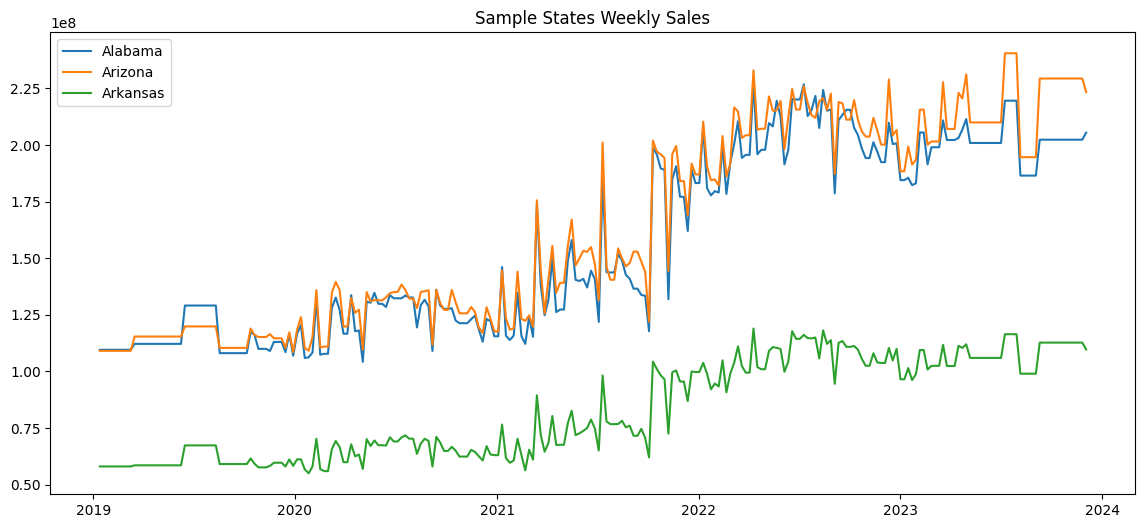

In [33]:
plt.figure(figsize=(14,6))

for s in df["state"].unique()[:3]:
    ts = weekly_series(df[df["state"]==s])
    plt.plot(ts, label=s)

plt.legend()
plt.title("Sample States Weekly Sales")
plt.show()


In [34]:
forecast_horizon = 8
results = []

states = df["state"].unique()


In [19]:
forecast_horizon = 8
states = df["state"].unique()

results = []


In [35]:
for state in states:

    print("Training:", state)

    sdf = df[df["state"]==state]
    ts = weekly_series(sdf)

    train_ts = ts[:-forecast_horizon]
    test_ts  = ts[-forecast_horizon:]

    # =====================================================
    # ARIMA
    # =====================================================
    arima = ARIMA(train_ts, order=(2,1,2)).fit()
    arima_fc = arima.forecast(forecast_horizon)

    # =====================================================
    # SARIMA
    # =====================================================
    sarima = SARIMAX(train_ts,
                     order=(2,1,2),
                     seasonal_order=(1,1,1,52)).fit()
    sarima_fc = sarima.forecast(forecast_horizon)

    # =====================================================
    # PROPHET
    # =====================================================
    p_df = ts.reset_index()
    p_df.columns = ["ds","y"]

    model_p = Prophet(weekly_seasonality=True)
    model_p.fit(p_df[:-forecast_horizon])

    future = model_p.make_future_dataframe(periods=forecast_horizon, freq="W")
    fc = model_p.predict(future)

    prophet_fc = fc["yhat"].tail(forecast_horizon).values

    # =====================================================
    # XGBOOST + FEATURES
    # =====================================================
    feat = create_features(ts)

    X = feat.drop("sales", axis=1)
    y = feat["sales"]

    split = len(X)-forecast_horizon

    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    model_xgb = xgb.XGBRegressor(n_estimators=400)
    model_xgb.fit(X_train, y_train)

    xgb_fc = model_xgb.predict(X_test)

    # =====================================================
    # LSTM
    # =====================================================
    scaler = MinMaxScaler()

    scaled = scaler.fit_transform(ts.values.reshape(-1,1))

    def seq(data, step=8):
        X,y=[],[]
        for i in range(len(data)-step):
            X.append(data[i:i+step])
            y.append(data[i+step])
        return np.array(X), np.array(y)

    X_seq, y_seq = seq(scaled)

    split = len(X_seq)-forecast_horizon

    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]

    model_lstm = Sequential([
        LSTM(64, activation='relu', input_shape=(8,1)),
        Dense(1)
    ])

    model_lstm.compile(optimizer="adam", loss="mse")
    model_lstm.fit(X_train, y_train, epochs=20, verbose=0)

    lstm_fc = model_lstm.predict(X_test)
    lstm_fc = scaler.inverse_transform(lstm_fc).flatten()

    # =====================================================
    # SAVE
    # =====================================================
    for i, date in enumerate(test_ts.index):
        results.append([
            state, date, test_ts.values[i],
            arima_fc.values[i],
            sarima_fc.values[i],
            prophet_fc[i],
            xgb_fc[i],
            lstm_fc[i]
        ])


Training: Alabama


12:47:40 - cmdstanpy - INFO - Chain [1] start processing
12:47:41 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
Training: Arizona


12:48:38 - cmdstanpy - INFO - Chain [1] start processing
12:48:38 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
Training: Arkansas


12:49:24 - cmdstanpy - INFO - Chain [1] start processing
12:49:24 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
Training: California


12:50:12 - cmdstanpy - INFO - Chain [1] start processing
12:50:12 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
Training: Colorado


12:51:03 - cmdstanpy - INFO - Chain [1] start processing
12:51:03 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
Training: Connecticut


12:51:51 - cmdstanpy - INFO - Chain [1] start processing
12:51:51 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
Training: Florida


12:53:07 - cmdstanpy - INFO - Chain [1] start processing
12:53:07 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Training: Georgia


12:53:51 - cmdstanpy - INFO - Chain [1] start processing
12:53:51 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
Training: Illinois


12:54:24 - cmdstanpy - INFO - Chain [1] start processing
12:54:24 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
Training: Indiana


12:55:12 - cmdstanpy - INFO - Chain [1] start processing
12:55:12 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
Training: Iowa


12:55:57 - cmdstanpy - INFO - Chain [1] start processing
12:55:57 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
Training: Kansas


12:56:44 - cmdstanpy - INFO - Chain [1] start processing
12:56:44 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
Training: Kentucky


12:57:26 - cmdstanpy - INFO - Chain [1] start processing
12:57:26 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
Training: Louisiana


12:58:20 - cmdstanpy - INFO - Chain [1] start processing
12:58:20 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
Training: Maine


12:59:13 - cmdstanpy - INFO - Chain [1] start processing
12:59:13 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
Training: Maryland


13:00:02 - cmdstanpy - INFO - Chain [1] start processing
13:00:02 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
Training: Massachusetts


13:00:57 - cmdstanpy - INFO - Chain [1] start processing
13:00:57 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
Training: Michigan


13:01:42 - cmdstanpy - INFO - Chain [1] start processing
13:01:42 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
Training: Minnesota


13:02:15 - cmdstanpy - INFO - Chain [1] start processing
13:02:16 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
Training: Mississippi


13:02:57 - cmdstanpy - INFO - Chain [1] start processing
13:02:57 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
Training: Missouri


13:03:31 - cmdstanpy - INFO - Chain [1] start processing
13:03:31 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
Training: Nebraska


13:04:34 - cmdstanpy - INFO - Chain [1] start processing
13:04:34 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
Training: Nevada


13:05:06 - cmdstanpy - INFO - Chain [1] start processing
13:05:06 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
Training: New Hampshire


13:05:58 - cmdstanpy - INFO - Chain [1] start processing
13:05:58 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
Training: New Mexico


13:06:40 - cmdstanpy - INFO - Chain [1] start processing
13:06:40 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
Training: New York


13:07:35 - cmdstanpy - INFO - Chain [1] start processing
13:07:35 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
Training: North Carolina


13:08:23 - cmdstanpy - INFO - Chain [1] start processing
13:08:23 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
Training: Ohio


13:09:07 - cmdstanpy - INFO - Chain [1] start processing
13:09:07 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
Training: Oklahoma


13:09:49 - cmdstanpy - INFO - Chain [1] start processing
13:09:49 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
Training: Oregon


13:10:36 - cmdstanpy - INFO - Chain [1] start processing
13:10:36 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
Training: Pennsylvania


13:11:21 - cmdstanpy - INFO - Chain [1] start processing
13:11:21 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
Training: Rhode Island


13:12:10 - cmdstanpy - INFO - Chain [1] start processing
13:12:10 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
Training: South Carolina


13:12:58 - cmdstanpy - INFO - Chain [1] start processing
13:12:58 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
Training: South Dakota


13:13:42 - cmdstanpy - INFO - Chain [1] start processing
13:13:42 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
Training: Tennessee


13:14:28 - cmdstanpy - INFO - Chain [1] start processing
13:14:28 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
Training: Texas


13:15:13 - cmdstanpy - INFO - Chain [1] start processing
13:15:13 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
Training: Utah


13:15:46 - cmdstanpy - INFO - Chain [1] start processing
13:15:46 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
Training: Vermont


13:16:32 - cmdstanpy - INFO - Chain [1] start processing
13:16:32 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
Training: Virginia


13:17:00 - cmdstanpy - INFO - Chain [1] start processing
13:17:00 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
Training: Washington


13:17:46 - cmdstanpy - INFO - Chain [1] start processing
13:17:46 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
Training: West Virginia


13:18:28 - cmdstanpy - INFO - Chain [1] start processing
13:18:28 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
Training: Wisconsin


13:19:17 - cmdstanpy - INFO - Chain [1] start processing
13:19:17 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
Training: Wyoming


13:20:21 - cmdstanpy - INFO - Chain [1] start processing
13:20:21 - cmdstanpy - INFO - Chain [1] done processing


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


In [38]:
res_df = pd.DataFrame(results,
    columns=["state","date","actual","ARIMA","SARIMA","Prophet","XGB","LSTM"])



In [39]:
def metrics(y,p):
    mae = mean_absolute_error(y,p)
    rmse = np.sqrt(mean_squared_error(y,p))
    mape = np.mean(np.abs((y-p)/y))*100
    return mae,rmse,mape

rows=[]

for model in ["ARIMA","SARIMA","Prophet","XGB","LSTM"]:
    mae,rmse,mape = metrics(res_df["actual"], res_df[model])
    rows.append([model,mae,rmse,mape])

metrics_df = pd.DataFrame(rows,
                          columns=["model","MAE","RMSE","MAPE"]).sort_values("MAE")

metrics_df


,model,MAE,RMSE,MAPE
4,LSTM,3.182371e+06,5.199076e+06,1.542184
3,XGB,4.000956e+06,6.833748e+06,2.002896
0,ARIMA,4.015449e+06,6.217070e+06,1.769636
1,SARIMA,5.329928e+06,9.756867e+06,2.312800
2,Prophet,9.549240e+06,1.310392e+07,5.060895


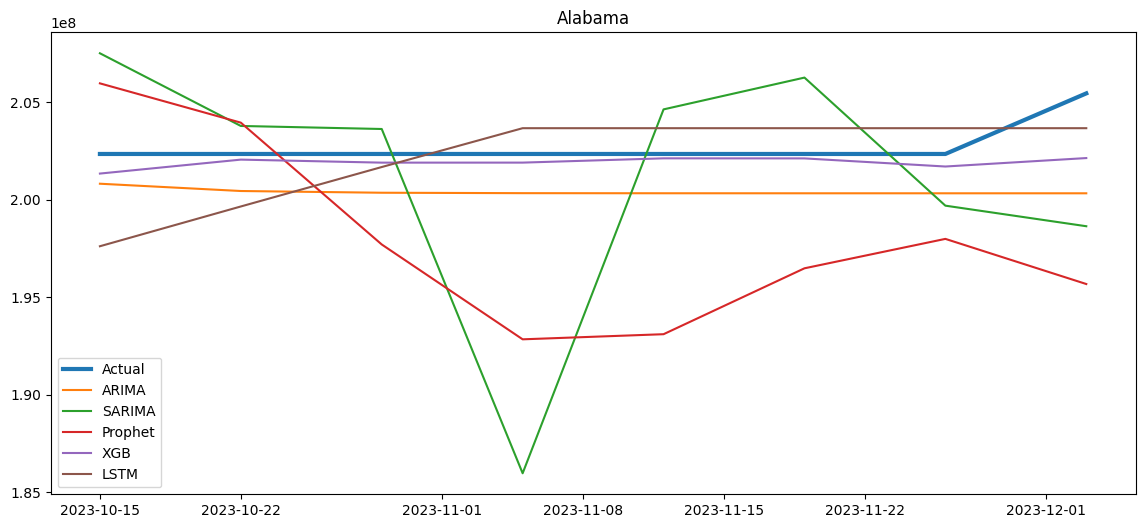

In [40]:
state_name = "Alabama"

temp = res_df[res_df["state"]==state_name]

plt.figure(figsize=(14,6))

plt.plot(temp["date"], temp["actual"], label="Actual", linewidth=3)

for m in ["ARIMA","SARIMA","Prophet","XGB","LSTM"]:
    plt.plot(temp["date"], temp[m], label=m)

plt.legend()
plt.title(state_name)
plt.show()


In [41]:
res_df.to_excel("state_forecasts.xlsx", index=False)
metrics_df.to_excel("model_metrics.xlsx", index=False)


In [48]:
df

,state,date,sales
0,Alabama,2019-01-12,109574036.0
1,Alabama,2019-03-11,112189103.8
2,Alabama,2019-06-10,129106730.4
3,Alabama,2019-08-12,108083723.8
4,Alabama,2019-10-11,110932912.8
...,...,...,...
7966,Wyoming,2023-07-05,23276821.3
7967,Wyoming,2023-08-01,19531016.1
7968,Wyoming,2023-09-04,21188735.7
7969,Wyoming,2023-12-02,20510613.7


In [50]:
from sklearn.metrics import mean_absolute_error
import numpy as np

models = ["ARIMA","SARIMA","Prophet","XGB","LSTM"]

best_rows = []

for state in res_df["state"].unique():
    
    temp = res_df[res_df["state"] == state]
    y_true = temp["actual"].values

    best_model = None
    best_mae = np.inf

    for m in models:
        mae = mean_absolute_error(y_true, temp[m].values)

        if mae < best_mae:
            best_mae = mae
            best_model = m

    best_rows.append([state, best_model, best_mae])


best_model_df = pd.DataFrame(
    best_rows,
    columns=["state","best_model","MAE"]
)

best_model_df.head(45)


,state,best_model,MAE
0,Alabama,XGB,8.242136e+05
1,Arizona,SARIMA,3.824414e+06
2,Arkansas,SARIMA,2.145108e+06
3,California,LSTM,1.153132e+07
4,Colorado,LSTM,1.917409e+06
5,Connecticut,XGB,9.446672e+05
6,Florida,ARIMA,9.557367e+06
7,Georgia,LSTM,3.514886e+06
8,Illinois,XGB,1.813847e+05
9,Indiana,XGB,3.128228e+06


In [51]:

best_model_df.to_csv("best_model_per_state.csv", index=False)


In [55]:
best_model_dict = dict(zip(best_model_df.state, best_model_df.best_model))


In [57]:
best_model_dict["Texas"]


'LSTM'

In [58]:
def get_state_series(state_name):
    
    sdf = df[df["state"] == state_name]
    
    ts = (
        sdf
        .set_index("date")["sales"]
        .resample("W")
        .mean()
        .ffill()
        .bfill()
    )
    
    return ts


In [59]:
def train_xgb(ts, horizon=8):

    feat = create_features(ts)

    X = feat.drop("sales", axis=1)
    y = feat["sales"]

    model = xgb.XGBRegressor(n_estimators=400)
    model.fit(X, y)

    last_row = X.iloc[-1:].copy()

    preds = []

    for _ in range(horizon):
        pred = model.predict(last_row)[0]
        preds.append(pred)

        last_row["lag_30"] = last_row["lag_7"]
        last_row["lag_7"] = last_row["lag_1"]
        last_row["lag_1"] = pred

    return preds


In [60]:
def train_lstm(ts, horizon=8):

    scaler = MinMaxScaler()

    scaled = scaler.fit_transform(ts.values.reshape(-1,1))

    def seq(data, step=8):
        X,y=[],[]
        for i in range(len(data)-step):
            X.append(data[i:i+step])
            y.append(data[i+step])
        return np.array(X), np.array(y)

    X_seq, y_seq = seq(scaled)

    model = Sequential([
        LSTM(64, activation='relu', input_shape=(8,1)),
        Dense(1)
    ])

    model.compile(loss="mse", optimizer="adam")
    model.fit(X_seq, y_seq, epochs=20, verbose=0)

    last_seq = scaled[-8:]
    preds = []

    for _ in range(horizon):
        pred = model.predict(last_seq.reshape(1,8,1), verbose=0)
        preds.append(pred[0][0])
        last_seq = np.append(last_seq[1:], pred)

    return scaler.inverse_transform(np.array(preds).reshape(-1,1)).flatten()


In [61]:
def train_prophet(ts, horizon=8):
    
    p_df = ts.reset_index()
    p_df.columns = ["ds","y"]
    
    model = Prophet(weekly_seasonality=True)
    model.fit(p_df)

    future = model.make_future_dataframe(periods=horizon, freq="W")
    fc = model.predict(future)

    return fc["yhat"].tail(horizon).values


In [62]:
def train_sarima(ts, horizon=8):
    model = SARIMAX(ts,
                    order=(2,1,2),
                    seasonal_order=(1,1,1,52)).fit()
    return model.forecast(horizon).values


In [63]:
def train_arima(ts, horizon=8):
    model = ARIMA(ts, order=(2,1,2)).fit()
    return model.forecast(horizon).values


In [64]:
def forecast_state(state_name, horizon=8):
    
    model_name = best_model_dict[state_name]
    
    ts = get_state_series(state_name)
    
    last_date = ts.index[-1]
    future_dates = pd.date_range(last_date + pd.Timedelta(weeks=1),
                                 periods=horizon,
                                 freq="W")

    if model_name == "ARIMA":
        preds = train_arima(ts, horizon)

    elif model_name == "SARIMA":
        preds = train_sarima(ts, horizon)

    elif model_name == "Prophet":
        preds = train_prophet(ts, horizon)

    elif model_name == "XGB":
        preds = train_xgb(ts, horizon)

    elif model_name == "LSTM":
        preds = train_lstm(ts, horizon)

    result = pd.DataFrame({
        "state": state_name,
        "date": future_dates,
        "model_used": model_name,
        "forecast": preds
    })

    return result


In [65]:
forecast_state("Texas")


,state,date,model_used,forecast
0,Texas,2023-12-10,LSTM,905051648.0
1,Texas,2023-12-17,LSTM,906014592.0
2,Texas,2023-12-24,LSTM,907164736.0
3,Texas,2023-12-31,LSTM,908516864.0
4,Texas,2024-01-07,LSTM,910075584.0
5,Texas,2024-01-14,LSTM,911813184.0
6,Texas,2024-01-21,LSTM,913775552.0
7,Texas,2024-01-28,LSTM,915973824.0


In [71]:
df[df['state'] == "Texas"]

,state,date,sales
6580,Texas,2019-01-12,472848726.3
6581,Texas,2019-03-11,481478332.5
6582,Texas,2019-06-10,541078907.2
6583,Texas,2019-08-12,471710634.7
6584,Texas,2019-10-11,483320678.6
...,...,...,...
6650,Texas,2023-07-05,962022026.5
6651,Texas,2023-08-01,811576956.8
6652,Texas,2023-09-04,897717811.9
6653,Texas,2023-12-02,843860928.2
